# <center> Capstone проект №3 <br> Прогнозирование временных рядов на карте

## <center> Неделя 5 <br>Прогнозирование с помощью регрессии

Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке!

In [1]:
import os
from glob import glob
import itertools
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model, ensemble,metrics
from scipy import stats
from tqdm import tqdm_notebook
import pickle

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

Для начала загрузим все имеющиеся данные:

In [3]:
with open('taxi.pkl','rb') as f:
    raw_data = pickle.load(f)

In [4]:
list_region = list(raw_data.columns)

In [5]:
print(f'В итоге имеем данные с {min(raw_data.index)} по {max(raw_data.index)}')

В итоге имеем данные с 2011-01-01 00:00:00 по 2016-06-30 23:00:00


В данных имеются некоторые дефекты. Исправим их:

In [6]:
data = raw_data.resample('H').sum()

In [20]:
data.head()

region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,33,68,23,39,156,261,287,354,371,128,...,12,0,4,20,20,11,1,47,1,19
2011-01-01 01:00:00,42,68,31,59,182,256,245,264,252,116,...,10,0,4,22,13,10,5,34,4,18
2011-01-01 02:00:00,40,59,18,62,170,225,228,255,235,99,...,14,0,4,1,1,0,2,11,2,0
2011-01-01 03:00:00,35,52,18,47,129,216,208,213,183,85,...,7,0,4,2,1,0,0,12,0,0
2011-01-01 04:00:00,17,29,9,31,83,149,185,173,142,63,...,13,0,3,1,2,0,0,4,1,0


Для ускорения обработки, будем работать с numpy массивом. DataFrame pandas у меня очень долго обрабатывался:

In [7]:
data_values = data.values

### Признаки для регрессии

Для каждой из шести задач прогнозирования $\hat{y}_{T+i|T}, i=1,\dots,6$ сформируем выборки. Откликом будет $y_{T+i}$ при всевозможных значениях T, а признаки будем использовать следующие:

- идентификатор географической зоны — категориальный

- год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так

- синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA 

- количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$ (параметр $K$ можно подбирать; попробуйте начать, например, с 6)

- количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}, \dots, y_{T-24*K_d}$ (параметр $K_d$ можно подбирать; попробуйте начать, например, с 2)

- суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц

Значения прогнозов ARIMA $\hat{y}_{T+i|T}^{ARIMA} $ я не использовал, так как они на прошлой недели получились совсем не очень, а новое обучение ARIMA занимает очень много времени.

Из прошлых недель зададим количество компонент Фурье и степени полинома. Параметры $K$ и $K_d$ зададим побольше ввиду того, что в дальнейшем будем использоваться модели Random Forest, которые устойчивы к избыточному количеству признаков:

(выборку сократил до 2 лет - иначе не хватает памяти при обучении)

In [23]:
    K = 23 # количество поездок за К часов
    K_d = 7 # количество поездок за К*24 часа
    k_week = 4 # количество Фурье компонент для недели
    k_year = 3 # количество Фурье компонент для года
    k_pol = 3 # степень полинома
    Y1 = []
    Y2 = []
    Y3 = []
    Y4 = []
    Y5 = []
    Y6 = []
    times = []
    fouriers = []
    regions = []
    years = []
    months = []
    weeks = []
    hours = []
    hour_trips = []
    day_trips = []
    total_half_day = []
    total_day = []
    total_week = []
    total_month = []
    sin_week = []
    cos_week = []
    sin_year = []
    cos_year = []
    polinom = []
    weather = []

    for region in tqdm_notebook(range(102)):
        for j in range(len(data.index) - 8760*2,len(data.index)-6):
            T = data.index[j]
            times.append(T)
            series = data_values[:j, region]
            t = len(series)
            # Фурье компоненты недели
            sin_week.append([np.sin(t * 2 * pi * (i+1) / 168) for i in range(k_week)])
            cos_week.append([np.cos(t * 2 * pi * (i+1) / 168) for i in range(k_week)])
            # Фурье компоненты года
            sin_year.append([np.sin(t * 2 * pi * (i+1) / 8760) for i in range(k_year)])
            cos_year.append([np.cos(t * 2 * pi * (i+1) / 8760) for i in range(k_year)])
            # Полиномы
            polinom.append([t**(i+1) for i in range(k_pol)])
            regions.append(list_region[region]) # идентификатор географической зоны
            years.append(T.year) # год
            months.append(T.month) # месяц
            weeks.append(T.weekday()) # день недели
            hours.append(T.hour) # час
            hour_trips.append([series[-1-t1] for t1 in range(K)]) # количество поездок за К часов
            day_trips.append([series[-1-(t+1)*24] for t in range(K_d)]) # количество поездок за К*24 часа
            total_half_day.append(series[-12:].sum()) # суммарное количество поездок за 12 часов
            total_day.append(series[-24:].sum()) # суммарное количество поездок за день
            total_week.append(series[-168:].sum()) # суммарное количество поездок за неделю
            total_month.append(series[-730:].sum()) # суммарное количество поездок за месяц
            # Для ускорения создаем сразу все 6 таргетов
            Y1.append(data_values[j+1, region])
            Y2.append(data_values[j+2, region])
            Y3.append(data_values[j+3, region])
            Y4.append(data_values[j+4, region])
            Y5.append(data_values[j+5, region])
            Y6.append(data_values[j+6, region])
    columns = ['region', 'year','month','weekday','hour']
    columns.extend([f'hour_trips{i+1}' for i in range(K)])
    columns.extend([f'day_trips{i+1}' for i in range(K_d)])
    columns.extend([f'sin_week{i+1}' for i in range(k_week)])
    columns.extend([f'cos_week{i+1}' for i in range(k_week)])
    columns.extend([f'sin_year{i+1}' for i in range(k_year)])
    columns.extend([f'cos_year{i+1}' for i in range(k_year)])
    columns.extend([f'polinom{i+1}' for i in range(k_pol)])    
    columns.extend(['total_half_day',
              'total_day','total_week','total_month','y1','y2','y3','y4','y5','y6'])

    samples = np.column_stack((regions,years,months,weeks,hours,hour_trips,day_trips,
                               sin_week,cos_week,sin_year,cos_year,polinom,
                               total_half_day,total_day,total_week,total_month,Y1,Y2,Y3,Y4,Y5,Y6))
    samples = pd.DataFrame(samples,columns=columns,index=times)

### Выборки и линейная модель

В качестве baseline попробуем линейную регрессию. Для этого закодируем некоторые категориальные признаки с помощью dummy-кодирования и  разделим каждую из шести выборок на три части:

In [17]:
y_train = []
y_control = []
y_test = []
X_train = pd.get_dummies(samples.iloc[:,:-6], columns=['region', 'year','month','weekday','hour'])[:'2016.04.30 17:00']
X_control = pd.get_dummies(samples.iloc[:,:-6], columns=['region', 'year','month','weekday','hour'])['2016.04.30 23:00':'2016.05.31 17:00']
X_test = pd.get_dummies(samples.iloc[:,:-6], columns=['region', 'year','month','weekday','hour'])['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [18]:
model = linear_model.LinearRegression().fit(X_train,y_train[0])
predict = model.predict(X_control)

Посмотрим на качество и графики предсказаний (для ускорения, пока что будем использовать только одну выборку из 6):

0.93996891951587
31.78774216588081


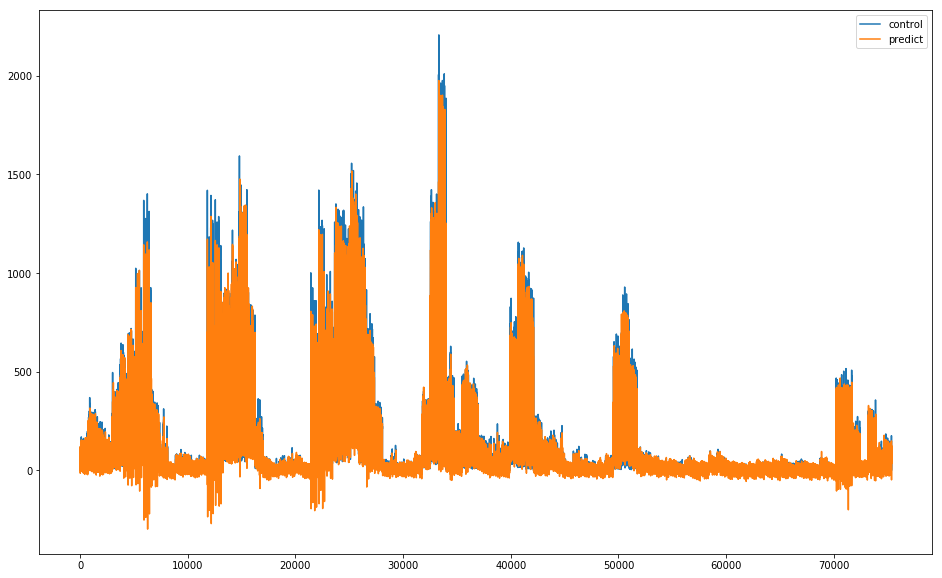

In [20]:
plt.figure(figsize=(16,10))
plt.plot(y_control[0].values,label='control')
plt.plot(model.predict(X_control),label='predict')
plt.legend()
print(model.score(X_control,y_control[0]))
print(metrics.mean_absolute_error(y_control[0], model.predict(X_control)))

Линейные модели достаточно хорошо описывают данные, но видно множество отрицательных значений.

### Random Forest

Далее попробуем Random Forest, еще раз создадим выборки, но уже без кодирования категориальных признаков:

In [28]:
y_train = []
y_control = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.04.30 17:00']
X_control = samples.iloc[:,:-6]['2016.04.30 23:00':'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [29]:
rf = ensemble.RandomForestRegressor(n_jobs=-1).fit(X_train,y_train[0])

0.9788011015718747
17.527290456101248


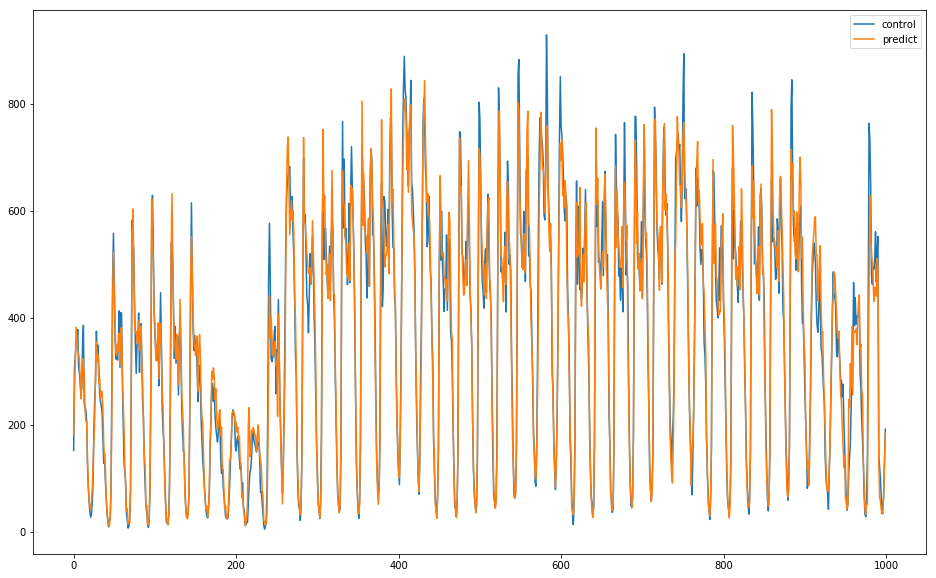

In [30]:
plt.figure(figsize=(16,10))
plt.plot(y_control[0].values[50000:51000],label='control')
plt.plot(rf.predict(X_control)[50000:51000],label='predict')
plt.legend()
print(rf.score(X_control,y_control[0]))
print(metrics.mean_absolute_error(y_control[0], rf.predict(X_control)))

Ошибка сократилась почти вдвое и визуально предсказания выглядят значительно лучше. Посмотрим на важность признаков:

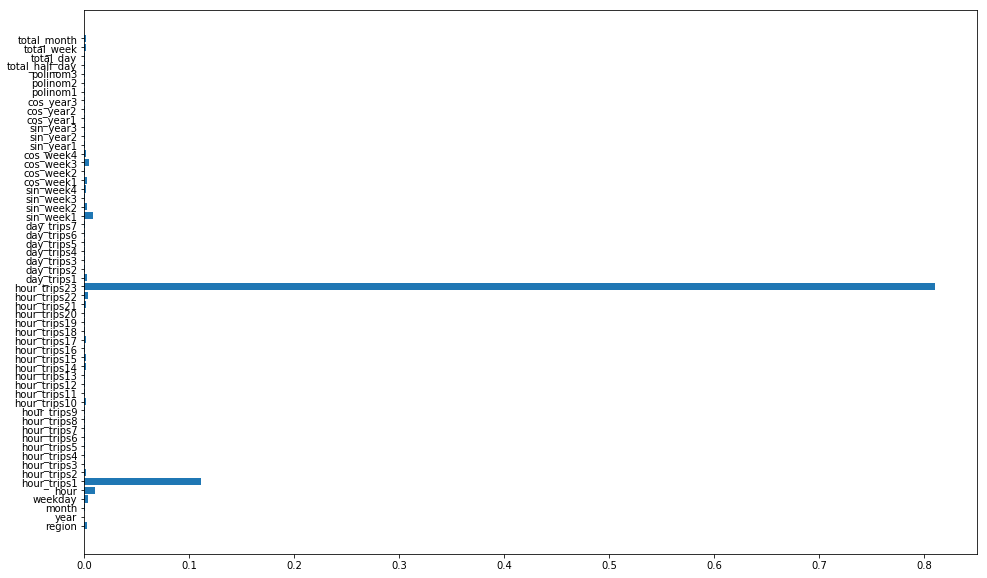

In [32]:
plt.figure(figsize=(16,10))
plt.barh(columns[:-6], rf.feature_importances_, align='center',log=False)
plt.show()

Самым важным признаком оказалось значения ряда 20-24 часа назад и пару часов назад и текущее. Также оказывают влияние номер ячейки, день недели, текущий час дня и первые компоненты рядов Фурье.

Текущий год и месяц (соответственно ряды Фурье годового периода и полиномы тренда) не играют существенной роли.

### Подбор гиперпараметров

Теперь попробуем улучшить наш результат подбором следующих гиперпараметров:
- Число признаков для выбора расщепления — max_features

При увеличении max_features увеличивается время построения леса, а деревья становятся «более однообразными». По умолчанию он равен sqrt(n) в задачах классификации и n/3 в задачах регрессии.

- Число деревьев — n_estimators

Чем больше деревьев, тем лучше качество, но время настройки и работы RF также пропорционально увеличиваются. Поэтому постараемся найти значение, когда качество на тесте выходит на асимптоту.

#### max_features

In [44]:
Q_train = []
Q_control = []
max_features  = range(1,len(X_train.columns),5)
for n in tqdm_notebook(max_features):
    model = ensemble.RandomForestRegressor(n_estimators=32,max_features = n,n_jobs=-1).fit(X_train.values,y_train[0].values)
    Q_train.append(metrics.mean_absolute_error(y_train[0], model.predict(X_train)))
    Q_control.append(metrics.mean_absolute_error(y_control[0], model.predict(X_control)))

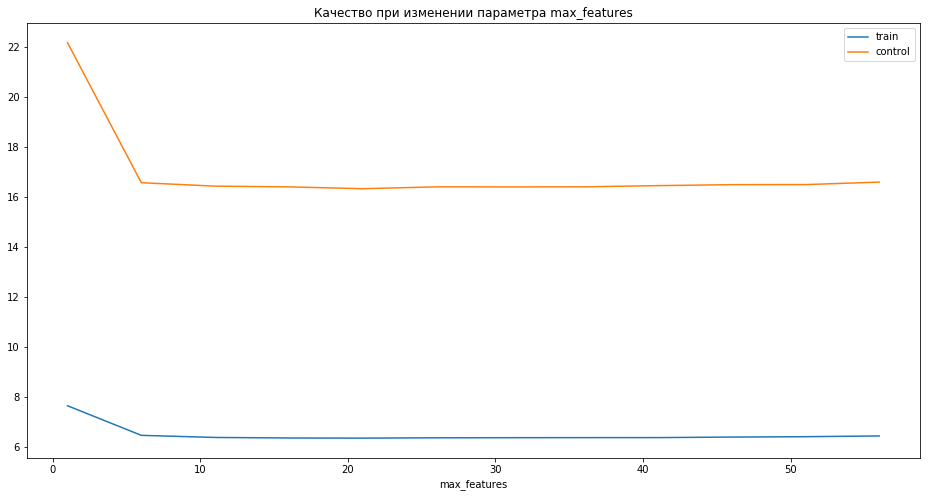

In [52]:
plt.figure(figsize=(16,8))
plt.plot(max_features, Q_train,label='train')
plt.plot(max_features, Q_control,label='control')
plt.xlabel('MAE')
plt.xlabel('max_features')
plt.title('Качество при изменении параметра max_features')
plt.legend()
plt.show()

Качество перестает изменяться примерно с 10 признаков, посмотрии поближе:

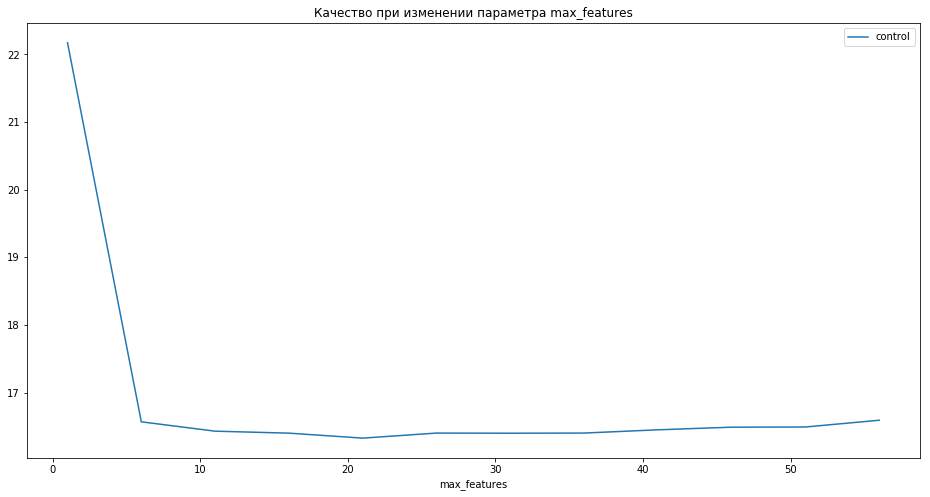

In [53]:
plt.figure(figsize=(16,8))
plt.plot(max_features, Q_control,label='control')
plt.xlabel('MAE')
plt.xlabel('max_features')
plt.title('Качество при изменении параметра max_features')
plt.legend()
plt.show()

Минимум примерно на 20, как и в рекомендациях n/3. Примем это значение для дальнейшего обучения

#### n_estimators

In [54]:
Q_train = []
Q_control = []
n_estimators  = range(10,100,5)
for n in tqdm_notebook(n_estimators):
    model = ensemble.RandomForestRegressor(max_features=10, n_estimators=n,n_jobs=-1).fit(X_train.values,y_train[0].values)
    Q_train.append(metrics.mean_absolute_error(y_train[0], model.predict(X_train)))
    Q_control.append(metrics.mean_absolute_error(y_control[0], model.predict(X_control)))

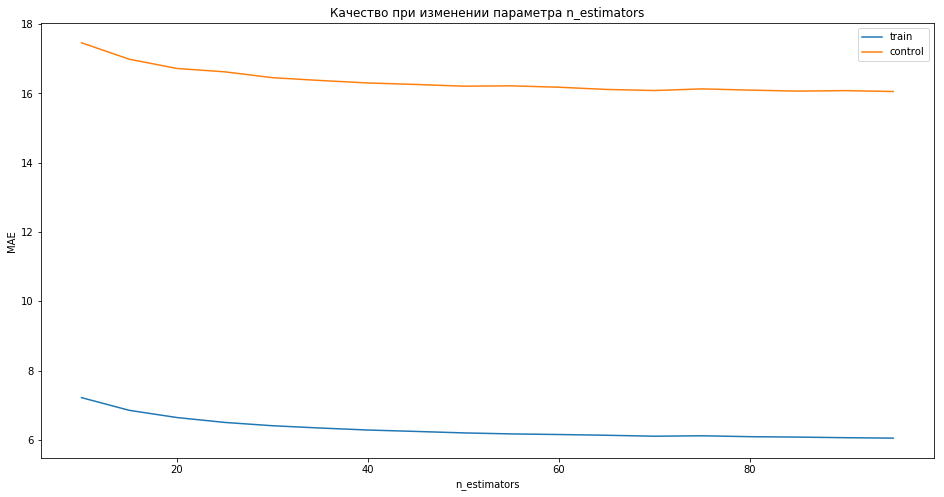

In [60]:
plt.figure(figsize=(16,8))
plt.plot(n_estimators, Q_train,label='train')
plt.plot(n_estimators, Q_control,label='control')
plt.ylabel('MAE')
plt.xlabel('n_estimators')
plt.title('Качество при изменении параметра n_estimators')
plt.legend()
plt.show()

Возможно надо было взять больший диапазон

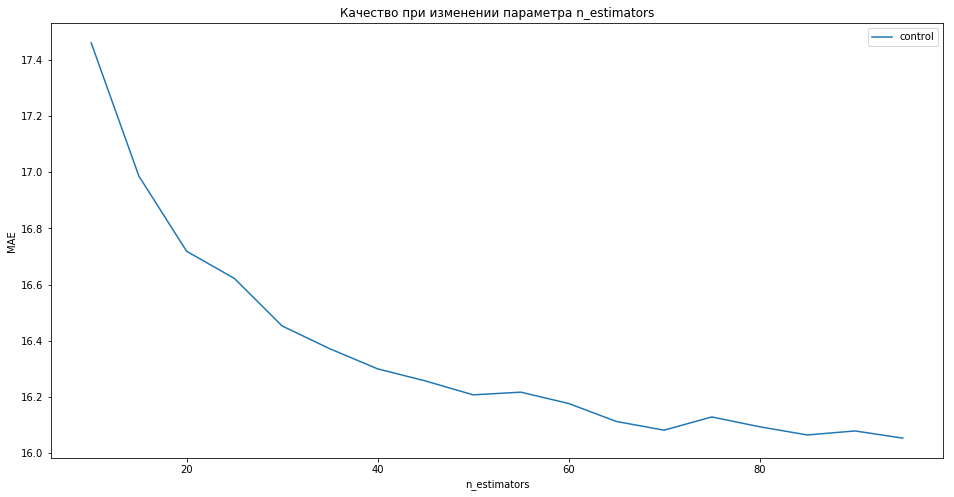

In [61]:
plt.figure(figsize=(16,8))
plt.plot(n_estimators, Q_control,label='control')
plt.ylabel('MAE')
plt.xlabel('n_estimators')
plt.title('Качество при изменении параметра n_estimators')
plt.legend()
plt.show()

Но мы примем 70 деревьев)

### Обучение моделей и оценка качества на данных мая

In [16]:
models = []
Q_control = []
for i in tqdm_notebook(range(6)):
    models.append(ensemble.RandomForestRegressor(n_estimators=70,max_features=20,n_jobs=16).fit(X_train.values,y_train[i].values))
    Q_control.append(metrics.mean_absolute_error(y_control[i], models[i].predict(X_control)))
Q_control = sum(Q_control) / 6
print(f'Ошибка прогноза: {Q_control:.1f}')


Ошибка прогноза: 17.5


В моем случае качество на порядок лучше, чем с ARIMAой

### Прогноз на июнь

Возможно стоило обучиться заново с включением майских данных, но качество и так было хорошее

In [18]:
predict = []
predict_kaggle = []
regions = X_test.region.values
for i in range(6):
    predict = models[i].predict(X_test)
    for j,t in enumerate(X_test.index):
        region = regions[j]
        idx = '_'.join([str(int(region)),str(t.date()),str(t.hour),str(i+1)])
        y = str((predict[j]))
        answer = ','.join([idx, y])
        predict_kaggle.append(answer)
print('\n'.join(predict_kaggle[:10]))

1075_2016-05-31_23_1,30.37142857142857
1075_2016-06-01_0_1,13.685714285714285
1075_2016-06-01_1_1,7.542857142857143
1075_2016-06-01_2_1,4.385714285714286
1075_2016-06-01_3_1,5.114285714285714
1075_2016-06-01_4_1,8.128571428571428
1075_2016-06-01_5_1,21.385714285714286
1075_2016-06-01_6_1,47.51428571428571
1075_2016-06-01_7_1,83.12857142857143
1075_2016-06-01_8_1,60.7


In [19]:
with open('results.csv','w') as f:
    f.write('id,y\n')
    f.write('\n'.join(predict_kaggle))

На kaggle получилось score = 16.75535

https://www.kaggle.com/submissions/7998274/7998274.zip

Спасибо за просмотр)